ACCIONA METODO ARIMA

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv("/Users/luciamenendezfernandez/Desktop/IBEX35_cotizaciones_20_Limpio.csv", sep=",")
df

,Fecha,Empresa,Precio_cierre
0,NaN,NaN,NaN
1,2005-04-01,ACCIONA,36.337158
2,2005-04-04,ACCIONA,35.794037
3,2005-04-05,ACCIONA,36.233715
4,2005-04-06,ACCIONA,36.388882
...,...,...,...
151101,2025-03-26,UNICAJA BANCO,1.774000
151102,2025-03-27,UNICAJA BANCO,1.749000
151103,2025-03-28,UNICAJA BANCO,1.710000
151104,2025-03-31,UNICAJA BANCO,1.706000


In [26]:
df_acciona = df[df["Empresa"] == "ACCIONA"]

In [27]:
df_acciona.to_csv('df_acciona.csv', index=False)


In [28]:
df_acciona['Fecha'] = pd.to_datetime(df_acciona['Fecha'], errors='coerce')


/var/folders/97/2shh3h_n7fbdbmbl6rvrwxtm0000gn/T/ipykernel_75787/1899683944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acciona['Fecha'] = pd.to_datetime(df_acciona['Fecha'], errors='coerce')


In [29]:
#Seleccionar solo las columnas necesarias y establecer el índice
df_acciona = df_acciona[['Fecha', 'Precio_cierre']].set_index('Fecha')

In [30]:
df_acciona.isnull().sum()

Precio_cierre    0
dtype: int64

In [31]:
df_acciona

,Precio_cierre
Fecha,
2005-04-01,36.337158
2005-04-04,35.794037
2005-04-05,36.233715
2005-04-06,36.388882
2005-04-07,36.285431
...,...
2025-03-26,122.099998
2025-03-27,121.000000
2025-03-28,122.900002


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

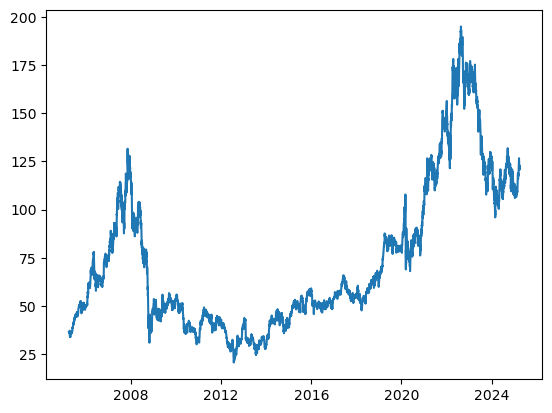

In [33]:
plt.plot(df_acciona)

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [35]:
SerieDescompuesta = seasonal_decompose(df_acciona, model="additive", period=12) 


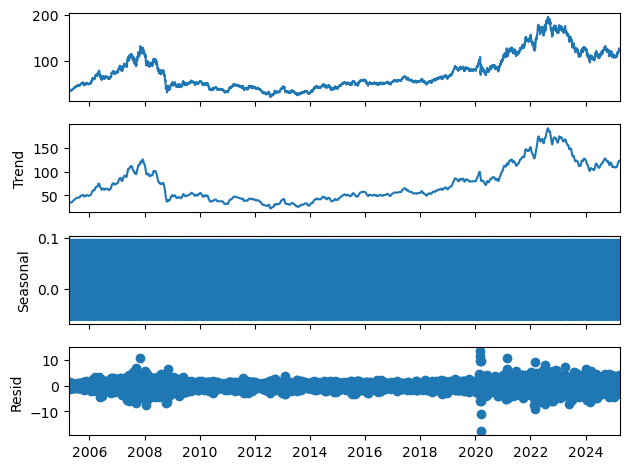

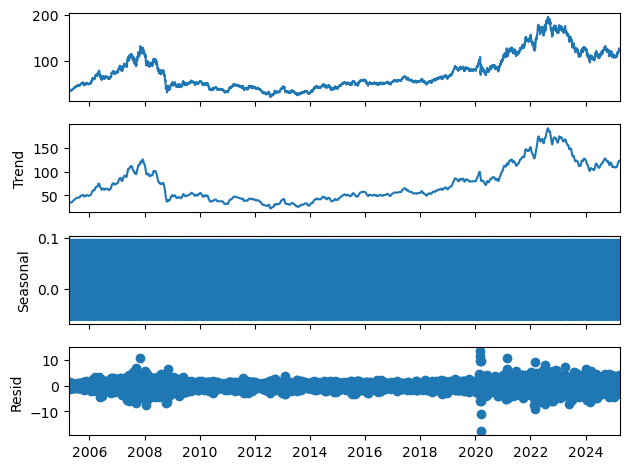

In [36]:
SerieDescompuesta.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)

In [37]:
pip install pmdarima


Note: you may need to restart the kernel to use updated packages.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error


In [39]:
result = adfuller(df_acciona)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print('➡️ La serie NO es estacionaria. Aplicaremos diferenciación.')
else:
    print('✅ La serie es estacionaria. Podemos continuar.')



ADF Statistic: -1.339337897866337
p-value: 0.6109886377237519
➡️ La serie NO es estacionaria. Aplicaremos diferenciación.


In [40]:
serie_diff = df_acciona.diff().dropna()

# Verificar de nuevo estacionariedad
result = adfuller(serie_diff)
print(f'Diferenciada - p-value: {result[1]}')
if result[1] > 0.05:
    print('➡️ La serie NO es estacionaria. Aplicaremos diferenciación.')
else:
    print('✅ La serie es estacionaria. Podemos continuar.')


Diferenciada - p-value: 5.763065560264779e-26
✅ La serie es estacionaria. Podemos continuar.


In [41]:
from scipy.stats import kruskal
import pandas as pd

# Si tu columna de cierre se llama, por ejemplo, 'close':
serie = df_acciona['Precio_cierre'].copy()
serie.index = pd.to_datetime(serie.index)

# Ahora sí puedes convertirla en DataFrame
serie_mes = serie.to_frame(name='valor')


# Crear una columna con el mes
serie_mes = serie.to_frame(name='valor')
serie_mes['mes'] = serie_mes.index.month

# Agrupar los valores por mes (1 a 12)
grupos = [grupo['valor'].values for nombre, grupo in serie_mes.groupby('mes')]

# Test de Kruskal-Wallis
stat, p = kruskal(*grupos)

print(f'Estadístico H: {stat:.4f}')
print(f'p-value     : {p:.4f}')

if p < 0.05:
    print('✅ Hay diferencias significativas entre los meses → posible estacionalidad anual.')
else:
    print('❌ No hay diferencias significativas entre los meses → no se detecta estacionalidad anual.')


Estadístico H: 9.3425
p-value     : 0.5903
❌ No hay diferencias significativas entre los meses → no se detecta estacionalidad anual.


In [42]:
from scipy.stats import kruskal
import pandas as pd

# Asegurarse de que el índice es datetime
df_acciona = df_acciona.copy()
df_acciona.index = pd.to_datetime(df_acciona.index)


### 1. Estacionalidad MENSUAL
df_acciona['mes'] = df_acciona.index.month
grupos_mes = [grupo['Precio_cierre'].values for _, grupo in df_acciona.groupby('mes')]
stat_mes, p_mes = kruskal(*grupos_mes)

print('[🔎 TEST ESTACIONALIDAD MENSUAL]')
print(f'Estadístico H: {stat_mes:.4f}')
print(f'p-value       : {p_mes:.4f}')
if p_mes < 0.05:
    print('✅ Hay diferencias significativas entre los meses → posible estacionalidad anual.\n')
else:
    print('❌ No hay diferencias significativas entre los meses → no se detecta estacionalidad anual.\n')


### 2. Estacionalidad SEMANAL
df_acciona['dia_semana'] = df_acciona.index.dayofweek
grupos_semana = [grupo['Precio_cierre'].values for _, grupo in df_acciona.groupby('dia_semana')]
stat_sem, p_sem = kruskal(*grupos_semana)

print('[🔎 TEST ESTACIONALIDAD SEMANAL]')
print(f'Estadístico H: {stat_sem:.4f}')
print(f'p-value       : {p_sem:.4f}')
if p_sem < 0.05:
    print('✅ Hay diferencias significativas entre los días de la semana → posible estacionalidad semanal.\n')
else:
    print('❌ No hay diferencias significativas entre los días de la semana → no se detecta estacionalidad semanal.\n')


### 3. Estacionalidad TRIMESTRAL
df_acciona['trimestre'] = df_acciona.index.quarter
grupos_trim = [grupo['Precio_cierre'].values for _, grupo in df_acciona.groupby('trimestre')]
stat_trim, p_trim = kruskal(*grupos_trim)

print('[🔎 TEST ESTACIONALIDAD TRIMESTRAL]')
print(f'Estadístico H: {stat_trim:.4f}')
print(f'p-value       : {p_trim:.4f}')
if p_trim < 0.05:
    print('✅ Hay diferencias significativas entre los trimestres → posible estacionalidad trimestral.\n')
else:
    print('❌ No hay diferencias significativas entre los trimestres → no se detecta estacionalidad trimestral.\n')



[🔎 TEST ESTACIONALIDAD MENSUAL]
Estadístico H: 9.3425
p-value       : 0.5903
❌ No hay diferencias significativas entre los meses → no se detecta estacionalidad anual.

[🔎 TEST ESTACIONALIDAD SEMANAL]
Estadístico H: 0.0853
p-value       : 0.9991
❌ No hay diferencias significativas entre los días de la semana → no se detecta estacionalidad semanal.

[🔎 TEST ESTACIONALIDAD TRIMESTRAL]
Estadístico H: 8.1936
p-value       : 0.0422
✅ Hay diferencias significativas entre los trimestres → posible estacionalidad trimestral.



In [43]:
# Definir fecha de corte
fecha_test = '2022-04-01'

# División
train = df_acciona[df_acciona.index < fecha_test]
test = df_acciona[df_acciona.index >= fecha_test]

print(f"Train: {train.index.min().date()} → {train.index.max().date()}")
print(f"Test : {test.index.min().date()} → {test.index.max().date()}")



Train: 2005-04-01 → 2022-03-31
Test : 2022-04-01 → 2025-04-01


In [44]:
pip install pmdarima


Note: you may need to restart the kernel to use updated packages.


In [45]:
from pmdarima import auto_arima


# Entrenamiento para serie SIN estacionalidad
modelo_auto = auto_arima(
    train['Precio_cierre'],
    d=None,                 # Deja que auto_arima determine el orden de diferenciación no estacional
    seasonal=False,         # Desactiva el componente estacional
    trace=True,             # Muestra el proceso de búsqueda
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(modelo_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15469.663, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15474.535, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15468.375, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15468.920, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15474.168, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15464.791, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15465.050, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15466.241, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15466.178, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15460.362, Time=0.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=15458.924, Time=0.49 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=15459.810, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=15460.744, Time=0.86 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=15469.708, Time=1.48 sec
 ARIMA(3,1,2)(0,0,0

In [46]:
# Parte no estacional: (p, d, q)
print("Orden ARIMA:", modelo_auto.order)

# Parte estacional: (P, D, Q, s)
print("Orden estacional:", modelo_auto.seasonal_order)


Orden ARIMA: (4, 1, 4)
Orden estacional: (0, 0, 0, 0)


In [47]:
import statsmodels.api as sm


In [48]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)


In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [50]:
model_arima = SARIMAX(train['Precio_cierre'], order=(4, 1, 4), seasonal_order=(0, 0, 0, 0))
model_arima_fit = model_arima.fit()

print(model_arima_fit.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77578D+00    |proj g|=  1.18529D-02

At iterate    5    f=  1.77561D+00    |proj g|=  2.41039D-03

At iterate   10    f=  1.77530D+00    |proj g|=  1.52015D-02

At iterate   15    f=  1.77504D+00    |proj g|=  1.59430D-03

At iterate   20    f=  1.77502D+00    |proj g|=  1.88882D-03

At iterate   25    f=  1.77499D+00    |proj g|=  1.24084D-04

At iterate   30    f=  1.77499D+00    |proj g|=  3.89575D-04

At iterate   35    f=  1.77499D+00    |proj g|=  6.08501D-05

At iterate   40    f=  1.77499D+00    |proj g|=  1.79571D-04

At iterate   45    f=  1.77499D+00    |proj g|=  1.14444D-04

At iterate   50    f=  1.77499D+00    |proj g|=  1.50131D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
# Número de períodos a predecir = longitud del test
n_periods = len(test)

# Predicción como Series con índice correcto
predicciones = model_arima_fit.forecast(steps=n_periods)
predicciones = pd.Series(predicciones.values, index=test.index)

# Asignar al DataFrame
test['Predicciones'] = predicciones


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/97/2shh3h_n7fbdbmbl6rvrwxtm0000gn/T/ipykernel_75787/2450149373.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicciones'] = predicciones


In [63]:
test

,Precio_cierre,Predicciones
Fecha,,
2022-04-01,159.258102,156.775842
2022-04-04,160.888748,156.943813
2022-04-05,165.780609,156.583191
2022-04-06,168.226562,156.641264
2022-04-07,169.404251,156.486672
...,...,...
2025-03-26,122.099998,156.651412
2025-03-27,121.000000,156.651412
2025-03-28,122.900002,156.651412


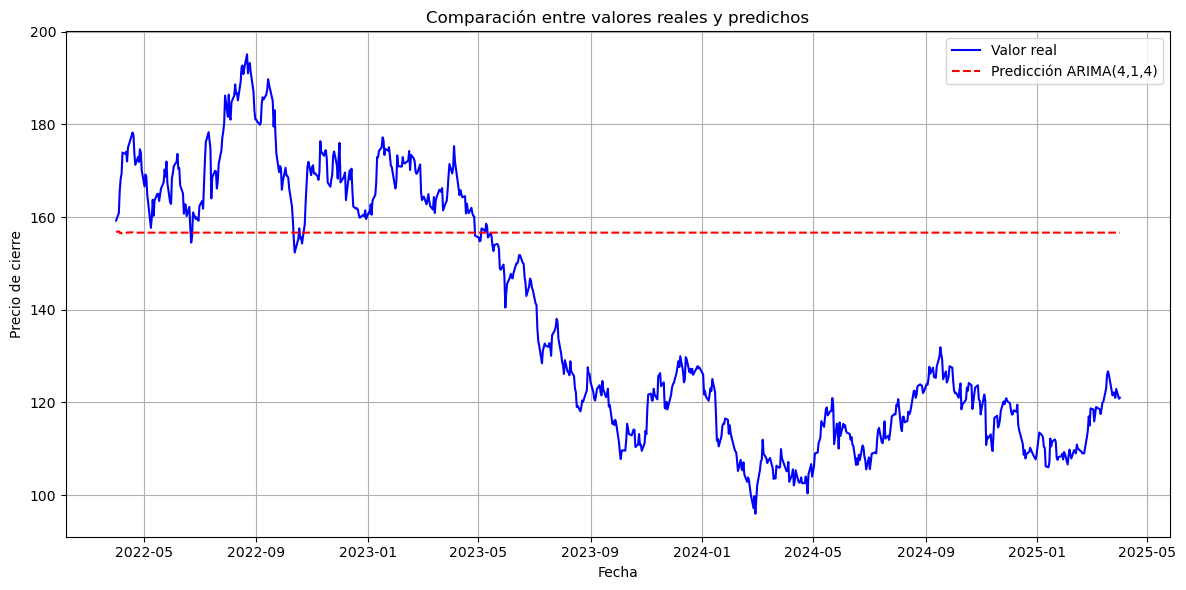

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Línea real (valores verdaderos del test)
plt.plot(test.index, test['Precio_cierre'], label='Valor real', color='blue')

# Línea de predicciones del modelo
plt.plot(test.index, test['Predicciones'], label='Predicción ARIMA(4,1,4)', color='red', linestyle='--')

# Título y etiquetas
plt.title('Comparación entre valores reales y predichos')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
test.drop(['dia_semana', 'mes', 'trimestre'], axis=1, inplace=True)


/var/folders/97/2shh3h_n7fbdbmbl6rvrwxtm0000gn/T/ipykernel_75787/3039512856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['dia_semana', 'mes', 'trimestre'], axis=1, inplace=True)


In [65]:
mse = ((test["Precio_cierre"] - test["Predicciones"])**2).mean()
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

RMSE:  32.67411901757006


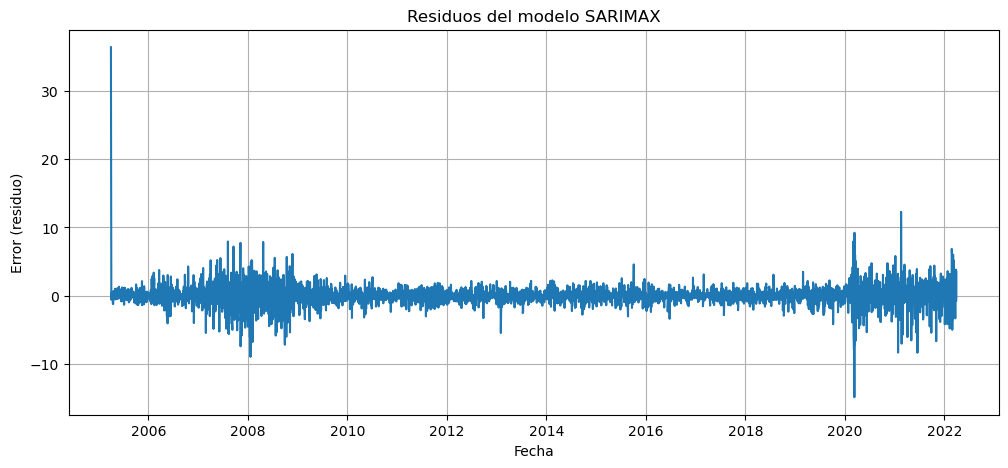

In [66]:
# Obtener los residuos (errores) del modelo
residuos_sarimax = model_arima_fit.resid

# Graficar los residuos
plt.figure(figsize=(12, 5))
plt.plot(residuos_sarimax)
plt.title("Residuos del modelo SARIMAX")
plt.xlabel("Fecha")
plt.ylabel("Error (residuo)")
plt.grid(True)
plt.show()


In [67]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_result = acorr_ljungbox(residuos_sarimax)
print(ljung_box_result)


     lb_stat  lb_pvalue
1   0.045941   0.830283
2   0.055368   0.972696
3   0.178892   0.980923
4   0.181520   0.996122
5   0.718634   0.981930
6   0.829901   0.991248
7   2.371597   0.936452
8   2.467658   0.963222
9   3.408324   0.945888
10  3.424779   0.969591


Como se obtienen p-valores superiores a 0,05 podemos asumir que no hay autocorrelación significativa y los residuos parecen aleatorios.

In [68]:
adf_test = adfuller(residuos_sarimax)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Statistic: -12.111870618809817
p-value: 1.9111157549664236e-22


Como obtenemos un p-valor muy cercano a 0 podemos concluir que los residuos son estacionarios.

In [69]:
print("Media de los residuos:", np.mean(residuos_sarimax))

Media de los residuos: 0.038547930979200375


* Verificamos que tengan varianza constante con a prueba de Breusch-Pagan:

In [70]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

exog = np.arange(len(residuos_sarimax))  # Variable independiente artificial
bp_test = het_breuschpagan(residuos_sarimax, sm.add_constant(exog))

print("p-value de Breusch-Pagan:", bp_test[1])

p-value de Breusch-Pagan: 0.3588508784373965


Como obtenemos un p-valor mayor que 0.05 podemos asumir que los residuos tienen varianza constante.